In [826]:
import torch
import math
from torch.distributions import Normal, Uniform
from torch.utils.data import TensorDataset, DataLoader
from torch import nn

from trickster import Trickster, Vanilla

torch.__version__

'0.4.1'

In [827]:
input_size = 1
hidden_size = 50
num_items = 20
batch_size = num_items
n_samples = 100

# train_size = 1000
# valid_size = 100


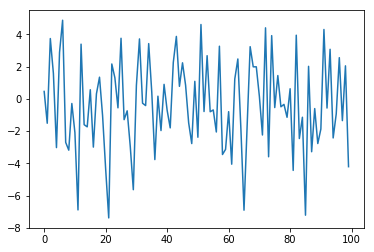

In [828]:
normal = Normal(torch.tensor([0.0]), torch.tensor([3.0]))
s = [normal.sample().item() for i in range(100)]
plt.plot(np.array(s))
plt.show()

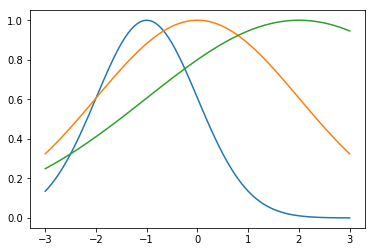

In [829]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x.copy() - mu, 2.) / (2 * np.power(sig, 2.)))

g = 0
for mu, sig in [(-1, 1), (0, 2), (2, 3)]:
    r = np.linspace(-3, 3, 100)
    g += gaussian(r, mu, sig)
    plt.plot(r, gaussian(r, mu, sig))
#plt.plot(r, g)



plt.show()

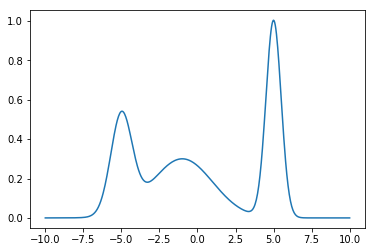

In [830]:

plt.plot(np.linspace(-10, 10, 500), 
             gaussian(np.linspace(-10, 10, 500), 5, 0.5) +
             0.3 * gaussian(np.linspace(-10, 10, 500), -1, 2) +
             0.5 * gaussian(np.linspace(-10, 10, 500), -5, 0.7))
plt.show()

200


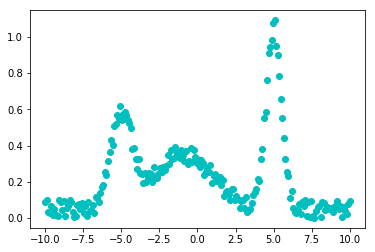

In [831]:
def n_gas(x_range, n_samples, means, stds, weights):
    x = np.linspace(-x_range, x_range, n_samples)
    g = sum(weight * gaussian(x, mean, std)
            for weight, mean, std in zip(weights, means, stds))
    print(len(g))
    g += 0.1 * np.random.random_sample(len(g))
    return x, g

x, y = n_gas(10, 200, [5, -1, -5], [0.5, 2, 0.7], [1, 0.3, 0.5])
plt.plot(x, y, 'co')
plt.show()
    
    
    
    

In [832]:
# x, g = n_gas(10, 200, np.random.randint(-5, 5, 3), np.random.random_sample(3), np.random.random_sample(3))
# plt.plot(x, g)
# plt.show()

In [833]:
def tensor_dataset(x, y):
    return TensorDataset(torch.tensor(x).float()[:, None], torch.tensor(y).float()[:, None])

def lobato(x):
    
    y = [(i ** 3) + normal.sample().item() for i in x]
    return x, y 

def two_x(x):
    y = [2 * i for i in x]
    return x, y

def cos(x):
#     y = [math.log(i ** 2) for i in x]
    y = [(math.cos(i)+ math.sin(i)) for i in x]
    return x, y

m = 4
uniform = Uniform(-m, m)
x_values = sorted([uniform.sample().item() for _ in range(num_items)])

x, y = lobato(x_values) # HARD
# # x, y = two_x(x_values) # EASY
# #x, y = cos(x_values) # EASY

dataset = tensor_dataset(x, y) # EASY
dataset = DataLoader(dataset, shuffle=True, batch_size=batch_size)

In [834]:
trick_model = Trickster(input_size, hidden_size, n_samples)
vanilla_model = Vanilla(input_size, hidden_size)

In [835]:
epochs = 500

def normalise(t): return (t - t.mean()) / t.std()

def fit(model):
    
    optim = torch.optim.Adam(model.parameters(), lr=0.1)
    
    beta = 0.5
    alpha = beta
    for e in range(epochs):
        for a, b in dataset:

    #         a = normalise(a)
    #         b = normalise(b)

            optim.zero_grad()

            mean, std = model(a, b)
            
            loss_a = torch.nn.MSELoss()(mean, b) 
            
            loss_b = std.mean()

            alpha += 0.001 * (loss_b.item() - beta)
            
            loss = loss_a + alpha * loss_b
            
            loss.backward()
            optim.step()
            
fit(vanilla_model)

In [836]:
import matplotlib.pyplot as plt  
import numpy as np  

x_range = np.arange(-7, 7, 0.1).tolist()

def plot(values, model):
    with torch.no_grad():
        
        plt.plot(np.array(x), np.array(y), 'bo')
        
        model.eval()
        mean, std = model(torch.tensor(values)[:, None])
        
        plt.plot(values, mean.numpy())
        print(std.mean())
        
        plt.plot(values, (mean + (3 * std)).numpy())
        plt.plot(values, (mean - (3 * std)).numpy())

        # plt.xlabel('time (s)')  
        # plt.ylabel('voltage (mV)')  
        # plt.title('voltage (mV) vs. time (sec)')   
        # plt.grid(True)  
        # plt.savefig("plot-voltage-vs.-time.png")  
        plt.show()  



tensor(2.9125)


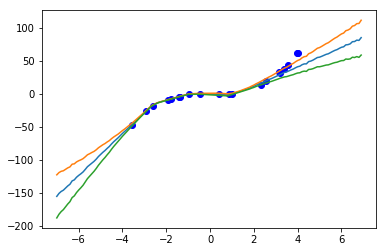

In [837]:
fit(trick_model)
plot(x_range, trick_model)

tensor(0.)


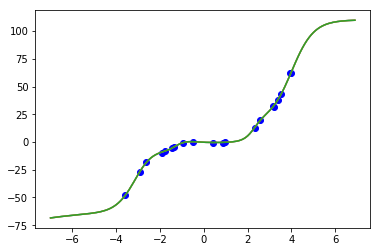

In [838]:
fit(vanilla_model)
plot(x_range, vanilla_model)

In [839]:
# validate
def validate(model):
    model.eval()
    with torch.no_grad():
        loss = torch.tensor([0.0])
        for a, b in dataset:
            mean, std = model(a, b)
            loss += torch.nn.MSELoss()(mean, b)
        return loss.mean()
        
print(f'Trickster -> {validate(trick_model)}')
print(f'Vanilla   -> {validate(vanilla_model)}')

Trickster -> 57.10968017578125
Vanilla   -> 0.34214431047439575
